## Uplift-моделирование

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils.validation import check_consistent_length
from IPython.display import Image, display
from sklift.metrics import uplift_at_k
from sklift.models import SoloModel
from catboost import CatBoostClassifier
from sklift.models import ClassTransformation
from sklift.models import TwoModels



pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data.csv')
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [3]:
df.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


#### Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [4]:
# преименование полей
df = df.rename(columns={'conversion': 'target', 'offer': 'treatment'})
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [5]:
df['treatment'].unique()

array(['Buy One Get One', 'No Offer', 'Discount'], dtype=object)

In [6]:
df['treatment'] = df['treatment'].apply(lambda i : 0 if i == 'No Offer' else 1)
df['treatment'].unique()

array([1, 0], dtype=int64)

#### Cделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

In [7]:
df = pd.get_dummies(df)
df['recency']=StandardScaler().fit_transform(df['recency'].to_numpy().reshape(-1,1))
df['history']=StandardScaler().fit_transform(df['history'].to_numpy().reshape(-1,1))
df.head(3)

,recency,history,used_discount,used_bogo,is_referral,treatment,target,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,1.207751,-0.389003,1,0,0,1,0,0,1,0,0,1,0
1,0.067359,0.339614,1,1,1,0,0,1,0,0,0,0,1
2,0.352457,-0.239836,0,1,1,1,0,0,1,0,0,0,1


#### Cделать разбиение набора данных не тренировочную и тестовую выборки

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1),
                                                    df['target'],
                                                    test_size=0.25,
                                                    random_state=42)

In [9]:
def plot_uplift_preds_(trmnt_preds, ctrl_preds, log=False, bins=100):
    """Plot histograms of treatment, control and uplift predictions.

    Args:
        trmnt_preds (1d array-like): Predictions for all observations if they are treatment.
        ctrl_preds (1d array-like): Predictions for all observations if they are control.
        log (bool): Logarithm of source samples. Default is False.
        bins (integer or sequence): Number of histogram bins to be used. Default is 100.
            If an integer is given, bins + 1 bin edges are calculated and returned.
            If bins is a sequence, gives bin edges, including left edge of first bin and right edge of last bin.
            In this case, bins is returned unmodified. Default is 100.

    Returns:
        Object that stores computed values.
    """

    # TODO: Add k as parameter: vertical line on plots
    check_consistent_length(trmnt_preds, ctrl_preds)
  
    if not isinstance(bins, int) or bins <= 0:
        raise ValueError(
            f'Bins should be positive integer. Invalid value for bins: {bins}')

    if log:
        trmnt_preds = np.log(trmnt_preds + 1)
        ctrl_preds = np.log(ctrl_preds + 1)

    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 7))
    axes[0].hist(
        trmnt_preds, bins=bins, alpha=0.3, color='b', label='Treated', histtype='stepfilled')
    axes[0].set_ylabel('Probability hist')
    axes[0].legend()
    axes[0].set_title('Treatment predictions')

    axes[1].hist(
        ctrl_preds, bins=bins, alpha=0.5, color='y', label='Not treated', histtype='stepfilled')
    axes[1].legend()
    axes[1].set_title('Control predictions')

    axes[2].hist(
        trmnt_preds - ctrl_preds, bins=bins, alpha=0.5, color='green', label='Uplift', histtype='stepfilled')
    axes[2].legend()
    axes[2].set_title('Uplift predictions')

    return axes

#### Провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

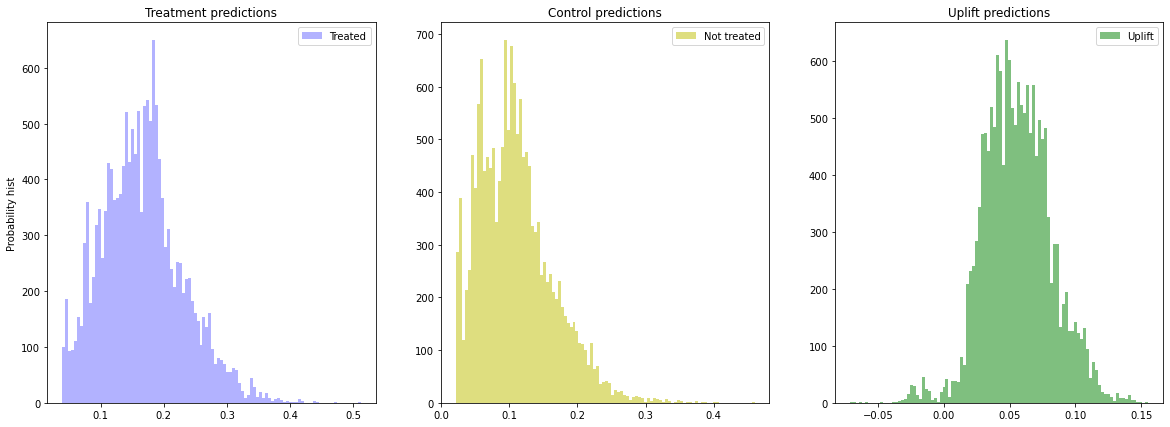

In [10]:
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

treat_train = X_train.treatment
treat_test = X_test.treatment

sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

sm_trmnt_preds = sm.trmnt_preds_
sm_ctrl_preds = sm.ctrl_preds_

plot_uplift_preds_(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [11]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,19.281390
1,treatment,14.812782
2,used_bogo,14.311984
3,recency,13.840232
4,history,11.043954
5,used_discount,7.862864
6,zip_code_Rural,6.974730
7,channel_Phone,4.169163
8,channel_Web,4.104178
9,zip_code_Urban,2.775721


In [12]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

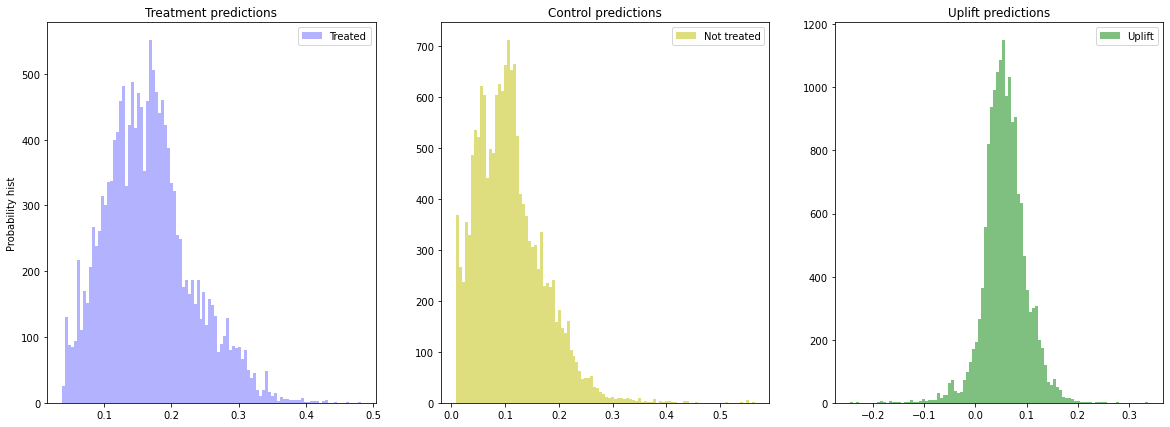

In [13]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)


models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds_(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

#### В конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [14]:
pd.DataFrame(data=models_results).sort_values('uplift@20%', ascending=False)

,approach,uplift@10%,uplift@20%
1,ClassTransformation,0.257624,0.221913
0,SoloModel,0.106899,0.102965
2,TwoModels,0.104090,0.095043


#### Построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [15]:
X_train_tree = X_train
features = [col for col in X_train_tree]

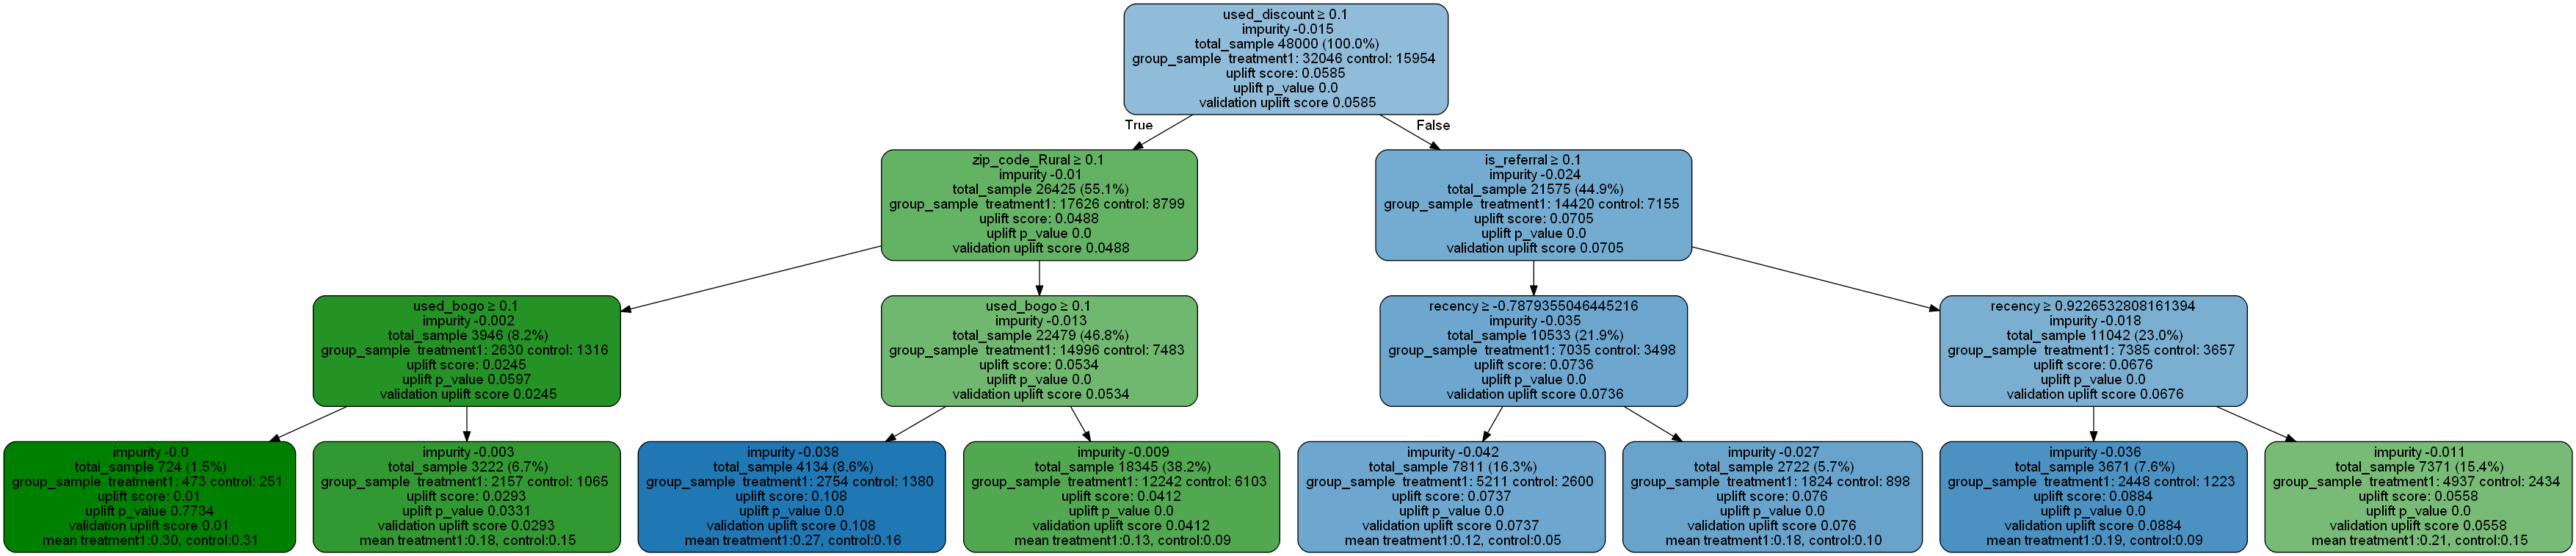

Wall time: 2.61 s


In [17]:
%%time
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=4, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
display(Image(graph.create_png()))

#### (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

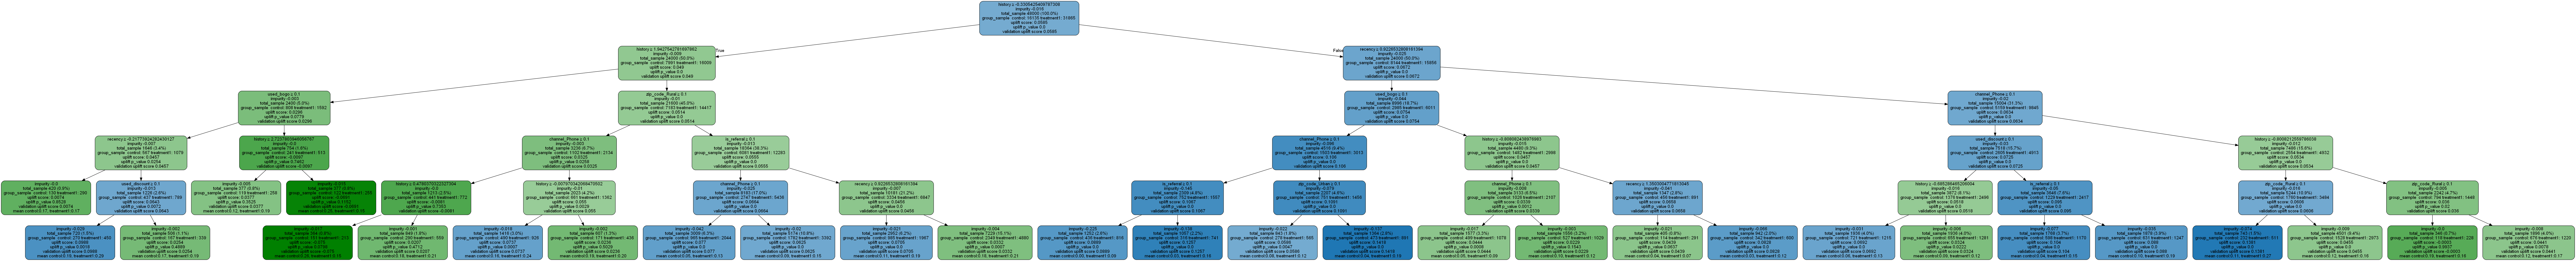

Wall time: 16.5 s


In [19]:
%%time
uplift_model = UpliftRandomForestClassifier(n_estimators=50, max_depth = 6, min_samples_leaf = 200, min_samples_treatment = 50, 
                                            n_reg = 100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train.values)

uplift_tree = uplift_model.uplift_forest[0]

graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree, features)
display(Image(graph.create_png()))